In [317]:
import pdb
import os
from pickletools import optimize
from shutil import SpecialFileError
import time
import random
import argparse
import datetime
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import accuracy, AverageMeter

from config import get_config
from models import build_model
from data import build_loader
from lr_scheduler import build_scheduler
from optimizer import build_optimizer
from logger import create_logger
from utils import load_checkpoint, load_pretrained, save_checkpoint, get_grad_norm, auto_resume_helper, reduce_tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [3]:
def parse_option(config_path, output_path, tag):
    parser = argparse.ArgumentParser('Swin Transformer training and evaluation script', add_help=False)
    parser.add_argument('--cfg', type=str, metavar="FILE", help='path to config file', 
                        default=config_path)
    parser.add_argument(
        "--opts",
        help="Modify config options by adding 'KEY VALUE' pairs. ",
        default=None,
        nargs='+',
    )

    # easy config modification
    parser.add_argument('--batch-size', type=int, help="batch size for single GPU")
    parser.add_argument('--data-path', type=str, help='path to dataset', default=1)
    parser.add_argument('--zip', action='store_true', help='use zipped dataset instead of folder dataset')
    parser.add_argument('--cache-mode', type=str, default='part', choices=['no', 'full', 'part'],
                        help='no: no cache, '
                             'full: cache all data, '
                             'part: sharding the dataset into nonoverlapping pieces and only cache one piece')
    parser.add_argument('--pretrained',
                        help='pretrained weight from checkpoint, could be imagenet22k pretrained weight')
    parser.add_argument('--resume', help='resume from checkpoint')
    parser.add_argument('--accumulation-steps', type=int, help="gradient accumulation steps")
    parser.add_argument('--use-checkpoint', action='store_true',
                        help="whether to use gradient checkpointing to save memory")
    parser.add_argument('--amp-opt-level', type=str, default='O0', choices=['O0', 'O1', 'O2'],
                        help='mixed precision opt level, if O0, no amp is used')
    parser.add_argument('--output', default=output_path, type=str, metavar='PATH',
                        help='root of output folder, the full path is <output>/<model_name>/<tag> (default: output)')
    parser.add_argument('--tag', help='tag of experiment', default=tag)
    parser.add_argument('--eval', action='store_true', help='Perform evaluation only')
    parser.add_argument('--throughput', action='store_true', help='Test throughput only')

    # distributed training
    parser.add_argument(
        "--local_rank", type=int, help='local rank for DistributedDataParallel', default=0
    )

    args, unparsed = parser.parse_known_args()

    config = get_config(args)

    return args, config

def build_val_loader(config):
    from data.build import build_dataset
    from timm.data import Mixup
    config.defrost()
    dataset_train, config.MODEL.NUM_CLASSES = build_dataset(is_train=True, config=config)
    config.freeze()
    dataset_val, _ = build_dataset(is_train=False, config=config)

    

    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=config.DATA.BATCH_SIZE,
        shuffle=False,
        num_workers=config.DATA.NUM_WORKERS,
        pin_memory=config.DATA.PIN_MEMORY,
        drop_last=False
    )

    # setup mixup / cutmix
    mixup_fn = None
    mixup_active = config.AUG.MIXUP > 0 or config.AUG.CUTMIX > 0. or config.AUG.CUTMIX_MINMAX is not None
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=config.AUG.MIXUP, cutmix_alpha=config.AUG.CUTMIX, cutmix_minmax=config.AUG.CUTMIX_MINMAX,
            prob=config.AUG.MIXUP_PROB, switch_prob=config.AUG.MIXUP_SWITCH_PROB, mode=config.AUG.MIXUP_MODE,
            label_smoothing=config.MODEL.LABEL_SMOOTHING, num_classes=config.MODEL.NUM_CLASSES)

    return dataset_val, data_loader_val, mixup_fn

@torch.no_grad()
def validate(config, data_loader, model, accumulation_steps=1):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    for idx, (images, target) in enumerate(data_loader):
        formatted_images = images.cuda(non_blocking=True).unsqueeze(0)
        formatted_target = target.cuda(non_blocking=True).unsqueeze(0)
        
        A, B, C, H, W = formatted_images.shape
        A, B = formatted_target.shape
        if B // accumulation_steps == 0:
            zero_idx = 1
            ones_idx = B
        else:
            zero_idx = accumulation_steps
            ones_idx = B // accumulation_steps
        formatted_images = formatted_images.reshape(zero_idx, ones_idx, C, H, W)
        formatted_target = formatted_target.reshape(zero_idx, ones_idx)
        
        for accumulation_step in range(accumulation_steps):
            images = formatted_images[accumulation_step]
            target = formatted_target[accumulation_step]
        
            # compute output
            output = model(images, use_amp=False)

            # measure accuracy and record loss
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

    #         acc1 = acc1
    #         acc5 = reduce_tensor(acc5)
    #         loss = reduce_tensor(loss)

            loss_meter.update(loss.item(), target.size(0))
            acc1_meter.update(acc1.item(), target.size(0))
            acc5_meter.update(acc5.item(), target.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if idx % config.PRINT_FREQ == 0:
                memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
                print(
                    f'Test: [{idx}/{len(data_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                    f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'
                    f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'
                    f'Mem {memory_used:.0f}MB')
            images = images.cpu()
            target = target.cpu()
    print(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg

In [52]:
id2label = {}
with open('/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python/id2label.txt', 'r') as handle:
    for idx, line in enumerate(handle):
        if idx % 2 == 0:
            element, label = line.strip().split(': ')
            id2label[int(element)] = label

# Swin Transformer Baseline

In [226]:
bl_config_path = 'configs/swin_tiny_patch4_window7_224_cifar100.yaml'
bl_output_path = '/srv/share4/gstoica3/checkpoints/swin_transformer_cifar'
bl_tag = 'baseline_fp32'
_, bl_config = parse_option(bl_config_path, bl_output_path, bl_tag)

=> merge config from configs/swin_tiny_patch4_window7_224_cifar100.yaml


In [227]:
bl_config

CfgNode({'BASE': [''], 'DATA': CfgNode({'BATCH_SIZE': 128, 'DATA_PATH': 1, 'DATASET': 'cifar100', 'IMG_SIZE': 224, 'INTERPOLATION': 'bicubic', 'ZIP_MODE': False, 'CACHE_MODE': 'part', 'PIN_MEMORY': True, 'NUM_WORKERS': 8}), 'MODEL': CfgNode({'TYPE': 'swin', 'NAME': 'swin_tiny_patch4_window7_224_cifar100', 'PRETRAINED': '', 'RESUME': '', 'NUM_CLASSES': 1000, 'DROP_RATE': 0.0, 'DROP_PATH_RATE': 0.2, 'LABEL_SMOOTHING': 0.1, 'SWIN': CfgNode({'PATCH_SIZE': 4, 'IN_CHANS': 3, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'NUM_HEADS': [3, 6, 12, 24], 'WINDOW_SIZE': 7, 'MLP_RATIO': 4.0, 'QKV_BIAS': True, 'QK_SCALE': None, 'APE': False, 'PATCH_NORM': True, 'SUMMARY_TYPE': 'none', 'SUMMARY_LAYERS': []}), 'SWIN_MLP': CfgNode({'PATCH_SIZE': 4, 'IN_CHANS': 3, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'NUM_HEADS': [3, 6, 12, 24], 'WINDOW_SIZE': 7, 'MLP_RATIO': 4.0, 'APE': False, 'PATCH_NORM': True}), 'CSAM': CfgNode({'APPROACH_NAME': 'Three_unmasked', 'POS_EMB_DIM': 0, 'SOFTMAX_TEMP': 1, 'PADDING': 'same',

In [237]:
seed = bl_config.SEED
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [238]:
bl_config.defrost()
bl_config.TRAIN.BASE_LR = .000001
bl_config.TRAIN.WARMUP_LR = .000001
bl_config.TRAIN.MIN_LR = .000001
bl_config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
bl_config.freeze()

In [239]:
dataset_val, data_loader_val, mixup_fn = build_val_loader(bl_config)

Files already downloaded and verified
Files already downloaded and verified


In [240]:
bl_model = build_model(bl_config)

In [241]:
bl_model.cuda()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [242]:
bl_resume_file = auto_resume_helper(bl_config.OUTPUT)

All checkpoints founded in /srv/share4/gstoica3/checkpoints/swin_transformer_cifar/swin_tiny_patch4_window7_224_cifar100/baseline_fp32: ['ckpt_epoch_11.pth', 'ckpt_epoch_228.pth', 'ckpt_epoch_143.pth', 'ckpt_epoch_285.pth', 'ckpt_epoch_254.pth', 'ckpt_epoch_192.pth', 'ckpt_epoch_144.pth', 'ckpt_epoch_282.pth', 'ckpt_epoch_253.pth', 'ckpt_epoch_195.pth', 'ckpt_epoch_16.pth', 'ckpt_epoch_138.pth', 'ckpt_epoch_64.pth', 'ckpt_epoch_18.pth', 'ckpt_epoch_136.pth', 'ckpt_epoch_221.pth', 'ckpt_epoch_131.pth', 'ckpt_epoch_226.pth', 'ckpt_epoch_63.pth', 'ckpt_epoch_213.pth', 'ckpt_epoch_104.pth', 'ckpt_epoch_87.pth', 'ckpt_epoch_56.pth', 'ckpt_epoch_5.pth', 'ckpt_epoch_178.pth', 'ckpt_epoch_80.pth', 'ckpt_epoch_51.pth', 'ckpt_epoch_2.pth', 'ckpt_epoch_268.pth', 'ckpt_epoch_214.pth', 'ckpt_epoch_103.pth', 'ckpt_epoch_266.pth', 'ckpt_epoch_171.pth', 'ckpt_epoch_23.pth', 'ckpt_epoch_24.pth', 'ckpt_epoch_89.pth', 'ckpt_epoch_58.pth', 'ckpt_epoch_261.pth', 'ckpt_epoch_176.pth', 'ckpt_epoch_35.pth', '

In [243]:
bl_config.defrost()
bl_config.MODEL.PRETRAINED = bl_resume_file
bl_config.freeze()

In [244]:
load_pretrained(bl_config, bl_model)

In [245]:
acc1, acc5, loss = validate(bl_config, data_loader_val, bl_model, accumulation_steps=4)

Test: [0/79]	Time 2.186 (2.186)	Loss 0.7454 (0.7454)	Acc@1 75.000 (75.000)	Acc@5 100.000 (100.000)	Mem 31937MB
Test: [0/79]	Time 0.071 (1.129)	Loss 0.7289 (0.7372)	Acc@1 84.375 (79.688)	Acc@5 93.750 (96.875)	Mem 31937MB
Test: [0/79]	Time 0.047 (0.768)	Loss 0.9836 (0.8193)	Acc@1 68.750 (76.042)	Acc@5 96.875 (96.875)	Mem 31937MB
Test: [0/79]	Time 0.053 (0.589)	Loss 0.6413 (0.7748)	Acc@1 87.500 (78.906)	Acc@5 100.000 (97.656)	Mem 31937MB
Test: [10/79]	Time 0.050 (0.102)	Loss 0.8635 (0.9322)	Acc@1 75.000 (77.134)	Acc@5 96.875 (94.436)	Mem 31937MB
Test: [10/79]	Time 0.046 (0.100)	Loss 1.2669 (0.9402)	Acc@1 71.875 (77.009)	Acc@5 87.500 (94.271)	Mem 31937MB
Test: [10/79]	Time 0.047 (0.099)	Loss 0.7704 (0.9363)	Acc@1 81.250 (77.108)	Acc@5 93.750 (94.259)	Mem 31937MB
Test: [10/79]	Time 0.048 (0.098)	Loss 1.1476 (0.9411)	Acc@1 68.750 (76.918)	Acc@5 93.750 (94.247)	Mem 31937MB
Test: [20/79]	Time 0.050 (0.075)	Loss 0.7611 (0.9311)	Acc@1 78.125 (76.890)	Acc@5 96.875 (94.406)	Mem 31937MB
Test: [20/7

In [21]:
for idx, (images, target) in enumerate(data_loader_val):
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)
    break

In [253]:
def obtain_baseline_model_features(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
        x = layer(x)
    return {
        'input_features': x.detach().cpu().numpy(),
        'output_features': layer(x).detach().cpu().numpy()
    }

In [22]:
features = obtain_baseline_model_features(model, images, 0)

In [24]:
features['input_features'].shape, features['output_features'].shape

(torch.Size([128, 3136, 96]), torch.Size([128, 784, 192]))

In [25]:
from sklearn.decomposition import PCA

In [26]:
input_PCA = PCA(n_components=3)
output_PCA = PCA(n_components=3)

In [30]:
input_PCA.fit(features['input_features'].detach().cpu().numpy().reshape(-1, 96))
output_PCA.fit(features['output_features'].detach().cpu().numpy().reshape(-1, 192))

PCA(n_components=3)

In [31]:
flattened_inputs = features['input_features'].detach().cpu().numpy().reshape(-1, 96)
flattened_outputs = features['output_features'].detach().cpu().numpy().reshape(-1, 192)

In [39]:
reduced_inputs = input_PCA.transform(flattened_inputs).reshape(128, 3136, 3).reshape(128, 56, 56, 3)
reduced_outputs = output_PCA.transform(flattened_outputs).reshape(128, 784, 3).reshape(128, 28, 28, 3)

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


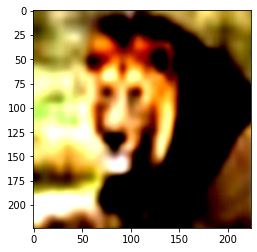

In [49]:
plt.imshow(images[117].permute(1, 2, 0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


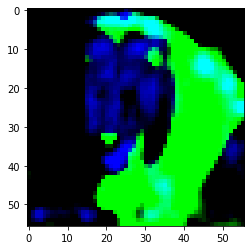

In [50]:
plt.imshow(reduced_inputs[117])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


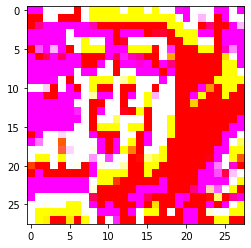

In [51]:
plt.imshow(reduced_outputs[117])

# CSAM Model

In [320]:
config_path = 'configs/csam_tiny_patch4_window7_224_cifar.yaml'
output_path = '/srv/share4/gstoica3/checkpoints/swin_csam1Appr3_transformer_cifar'
tag = 'filter_size_3'
_, config = parse_option(config_path, output_path, tag)

=> merge config from configs/csam_tiny_patch4_window7_224_cifar.yaml


In [321]:
seed = config.SEED
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [322]:
config.defrost()
config.TRAIN.BASE_LR = .000001
config.TRAIN.WARMUP_LR = .000001
config.TRAIN.MIN_LR = .000001
config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
config.freeze()

In [323]:
dataset_val, data_loader_val, mixup_fn = build_val_loader(config)

Files already downloaded and verified
Files already downloaded and verified


/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [324]:
csam_model = build_model(config)

ADDING CSAM!!!!


In [325]:
csam_model.cuda()
# csam_resume_file = auto_resume_helper(config.OUTPUT)
csam_resume_file = '/srv/share4/gstoica3/checkpoints/swin_csam1Appr3_transformer_cifar/csam_tiny_patch4_window7_224_cifar/filter_size_3/ckpt_epoch_291.pth'
config.defrost()
config.MODEL.PRETRAINED = csam_resume_file
config.freeze()
load_pretrained(config, csam_model)

In [326]:
csam_acc1, csam_acc5, csam_loss = validate(config, data_loader_val, csam_model, accumulation_steps=4)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test: [0/79]	Time 2.596 (2.596)	Loss 0.7629 (0.7629)	Acc@1 75.000 (75.000)	Acc@5 100.000 (100.000)	Mem 31937MB
Test: [0/79]	Time 0.105 (1.350)	Loss 0.6961 (0.7295)	Acc@1 84.375 (79.688)	Acc@5 93.750 (96.875)	Mem 31937MB
Test: [0/79]	Time 0.073 (0.924)	Loss 1.0143 (0.8244)	Acc@1 75.000 (78.125)	Acc@5 96.875 (96.875)	Mem 31937MB
Test: [0/79]	Time 0.084 (0.714)	Loss 0.6571 (0.7826)	Acc@1 87.500 (80.469)	Acc@5 100.000 (97.656)	Mem 31937MB
Test: [10/79]	Time 0.055 (0.118)	Loss 0.8248 (0.8883)	Acc@1 75.000 (79.116)	Acc@5 96.875 (95.122)	Mem 31937MB
Test: [10/79]	Time 0.051 (0.117)	Loss 1.2379 (0.8967)	Acc@1 75.000 (79.018)	Acc@5 84.375 (94.866)	Mem 31937MB
Test: [10/79]	Time 0.051 (0.115)	Loss 0.8682 (0.8960)	Acc@1 75.000 (78.924)	Acc@5 93.750 (94.840)	Mem 31937MB
Test: [10/79]	Time 0.051 (0.114)	Loss 0.9907 (0.8981)	Acc@1 71.875 (78.764)	Acc@5 96.875 (94.886)	Mem 31937MB
Test: [20/79]	Time 0.055 (0.085)	Loss 0.7432 (0.8830)	Acc@1 84.375 (78.974)	Acc@5 96.875 (94.946)	Mem 31937MB
Test: [20/7

In [13]:
for idx, (images, target) in enumerate(data_loader_val):
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)
    break

In [98]:
def get_csam_module(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
    return layer, x


def get_module_representation(self, batch):
    valid_elements = (1 - self.padding_mask)
    X = self.maybe_add_positional_encodings(batch)                                                                  # [B,H,W,E]
    batch_size, H, W, _ = X.shape
    X = X.view(-1, H * W, X.shape[-1])                                                                              # [B,HW,E]
    values = self.global_transform(X)                                                                               # [B,HW,C]

    X_normed = F.normalize(X, dim=-1)                                                                               # [B,HW,C]
    if self.approach_args.SIMILARITY_METRIC == 'cosine_similarity':
        scores = torch.bmm(X_normed, X_normed.transpose(2, 1))                                                      # [B,HW,HW]
    elif self.approach_args.SIMILARITY_METRIC == 'dot_product':
        scores = torch.bmm(X, X.transpose(2, 1))                                                                    # [B,HW,HW]
    attn = self.masked_softmax(                                                                                     # [B,HW,HW]
        scores, 
        mask=valid_elements.flatten().unsqueeze(0).unsqueeze(0),                                                    # Mask out padding indices [1, 1, HW]
        dim=-1, epsilon=1e-5 
    )                                                                                                               # [B,HW,HW]

    filter_vecs = torch.bmm(attn, values)                                                                           # [B,HW,C]
    filter_vals = (filter_vecs * X).sum(-1, keepdim=True)                                                           # [B,HW,C] x [B,HW,C] -> [B,HW,1]
    # weighted_X = self.forget_gate_nonlinearity(filter_vals) * X                                                   # [B,HW,C] x [B,HW,1] -> [B,HW,C]
    # output = torch.matmul(weighted_X.transpose(2, 1), local_mask).transpose(2, 1)                                 # [B,C,HW] x [HW,Nc] -> [B,C,Nc]
    output = self.forget_gate_nonlinearity(filter_raw=filter_vals, pooling_features=X)
    return filter_vals, attn

def extract_module_components(module, inputs):
    return_3 = False
    if len(inputs.shape) == 3:
        return_3 = True
        inputs = inputs.reshape(
            inputs.shape[0], 
            module.spatial_shape[0], 
            module.spatial_shape[1],
            module.spatial_shape[2]
        )
    # print('BATCH SHAPE: {}'.format(batch.shape))
    # print('EXPECTED INPUT SHAPE: {}'.format(self.spatial_shape))
    batch = inputs.permute(0, 3, 1, 2)
    batch = module.input_padder(batch)                                                                                # Pad batch for resolution reduction/preservation
    batch = batch.permute(0, 2, 3, 1)                                                                               # [B,C,H,W] -> [B,H,W,C]
    filter_values, attention_matrix = get_module_representation(self=module, batch=batch)

    return filter_values, attention_matrix
        

def obtain_csam_features(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
        x = layer(x)
    output_features = layer(x)
    input_features = x
    filter_values, attention_matrix = extract_module_components(module=layer, inputs=x)
    return {
        'input_features': x.detach().cpu().numpy(),
        'output_features': layer(x).detach().cpu().numpy(),
        'filter_values': filter_values.detach().cpu().numpy(),
        'attention_matrix': attention_matrix.detach().cpu().numpy()
    }

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [327]:
features = obtain_csam_features(csam_model, images, 1)

In [ ]:
bl_features = obtain_baseline_model_features(bl_model, images, 1)

In [255]:
bl_features['input_features'].shape, bl_features['output_features'].shape

((128, 784, 192), (128, 196, 384))

In [31]:
features['input_features'].shape, features['output_features'].shape, features['filter_values'].shape

((128, 784, 192), (128, 784, 192), (128, 900, 1))

In [33]:
from sklearn.decomposition import PCA

In [44]:
features_PCA = PCA(n_components=3)

In [256]:
concat_features = np.concatenate(
    (
        bl_features['input_features'].reshape(-1, 192),
        features['input_features'].reshape(-1, 192),
        features['output_features'].reshape(-1, 192)
    ),
    axis=0
)
features_PCA.fit(concat_features)
# output_PCA.fit(features['output_features'].reshape(-1, 192))

PCA(n_components=3)

In [257]:
flattened_inputs = features['input_features'].reshape(-1, 192)
flattened_outputs = features['output_features'].reshape(-1, 192)
bl_flattened_inputs = bl_features['input_features'].reshape(-1, 192)

In [258]:
reduced_inputs = features_PCA.transform(flattened_inputs).reshape(128, 784, 3).reshape(128, 28, 28, 3)
reduced_outputs = features_PCA.transform(flattened_outputs).reshape(128, 784, 3).reshape(128, 28, 28, 3)
bl_reduced_inputs = features_PCA.transform(bl_flattened_inputs).reshape(128, 784, 3).reshape(128, 28, 28, 3)

In [328]:
features['input_reduced'] = reduced_inputs
features['output_reduced'] = reduced_outputs
features['bl_input_reduced'] = bl_reduced_inputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


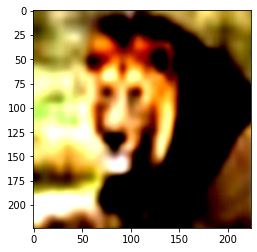

In [38]:
plt.imshow(images[117].permute(1, 2, 0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


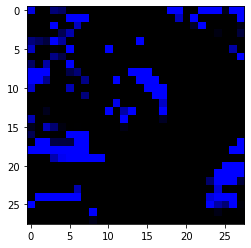

In [48]:
plt.imshow(reduced_inputs[117])

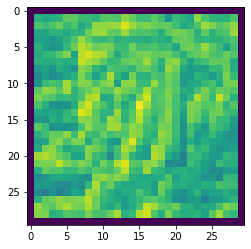

In [50]:
plt.imshow(features['filter_values'][117].reshape(30, 30))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


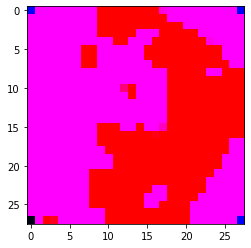

In [49]:
plt.imshow(reduced_outputs[117])

In [62]:
label_names = [id2label[i] for i in target.detach().cpu().numpy()]
cpu_images = images.permute(0, 2, 3, 1).detach().cpu().numpy()

In [260]:
def plot_layer_features(features, labels, images, index):
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
    fig.set_size_inches(20, 5)
    fig.suptitle("Feature Visualizations for an Image of {}".format(labels[index]))
    ax0.imshow(images[index])
    ax0.set_title("Image")
    ax1.imshow(sigmoid(features['input_reduced'][index]))
    ax1.set_title("Layer Input Representation")
    ax2.imshow(features['filter_values'][index].reshape(30, 30))
    ax2.set_title("Filter Representation")
    ax3.imshow(sigmoid(features['output_reduced'][index]))
    ax3.set_title("Layer Output Representation")
    ax4.imshow(sigmoid(features['bl_input_reduced'][index]))
    ax4.set_title("Baseline Layer Output")
    fig.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


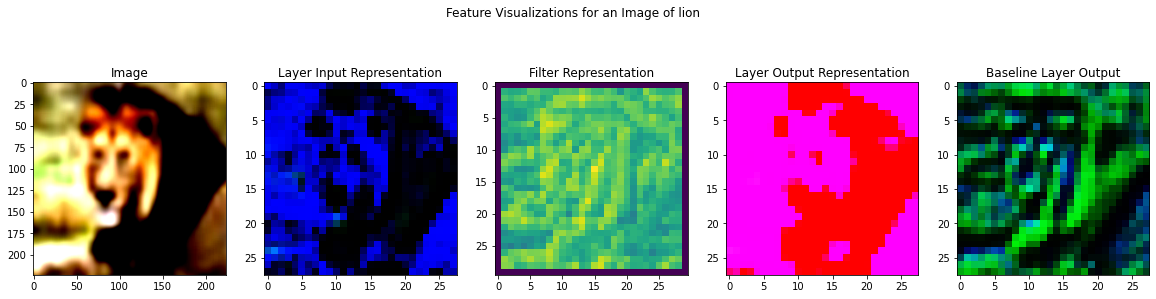

In [261]:
plot_layer_features(features, label_names, cpu_images, index=117)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


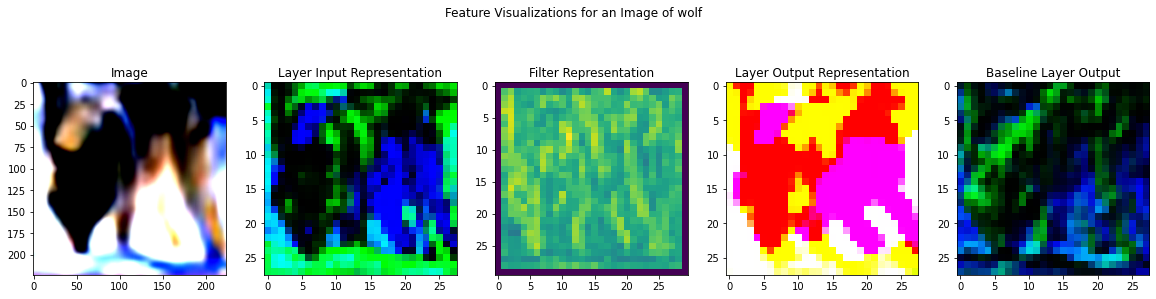

In [262]:
plot_layer_features(features, label_names, cpu_images, index=17)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


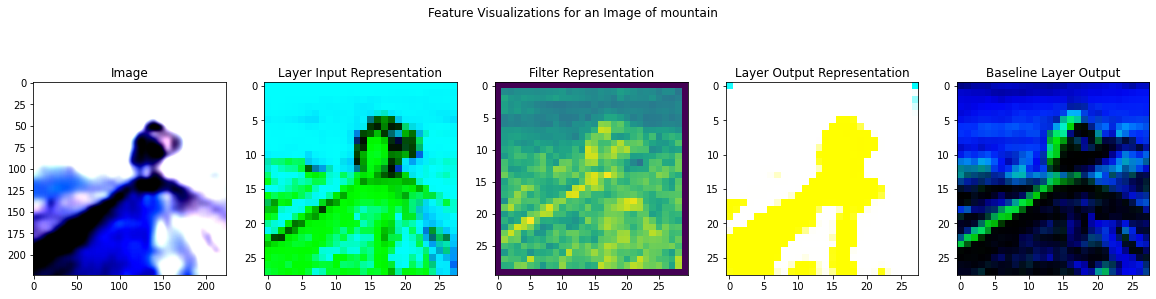

In [263]:
plot_layer_features(features, label_names, cpu_images, index=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in exp


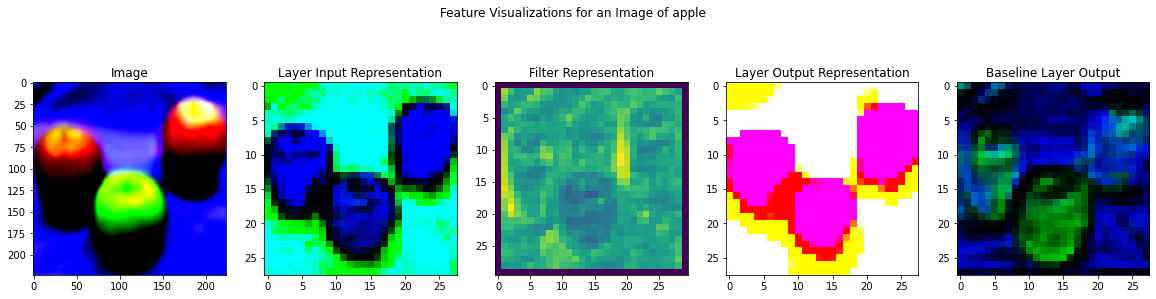

In [264]:
plot_layer_features(features, label_names, cpu_images, index=9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


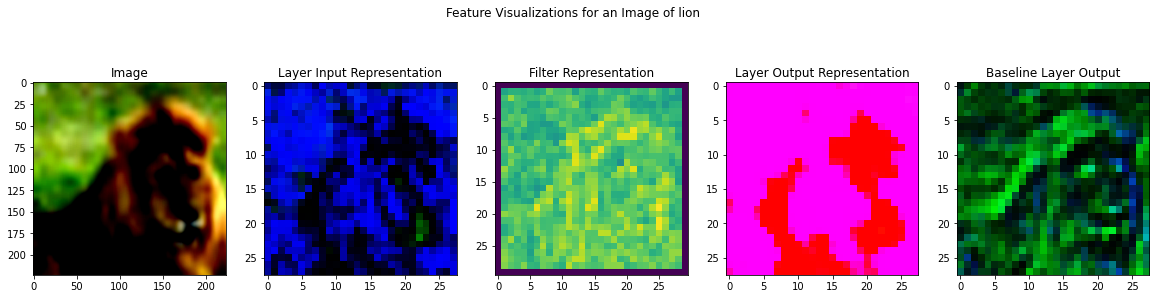

In [265]:
plot_layer_features(features, label_names, cpu_images, index=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


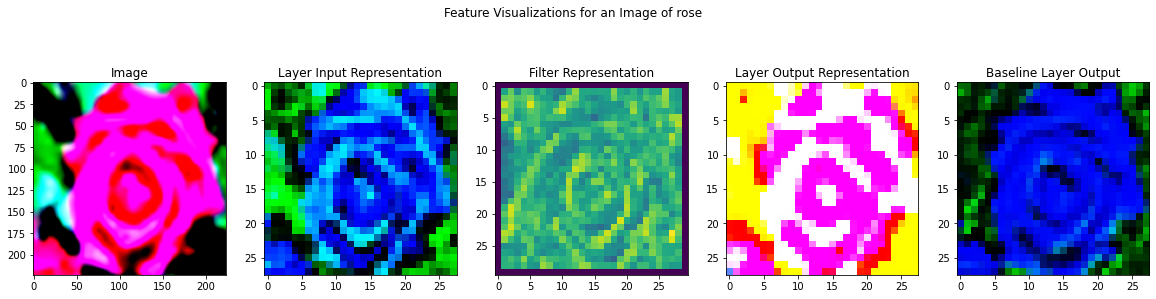

In [266]:
plot_layer_features(features, label_names, cpu_images, index=18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


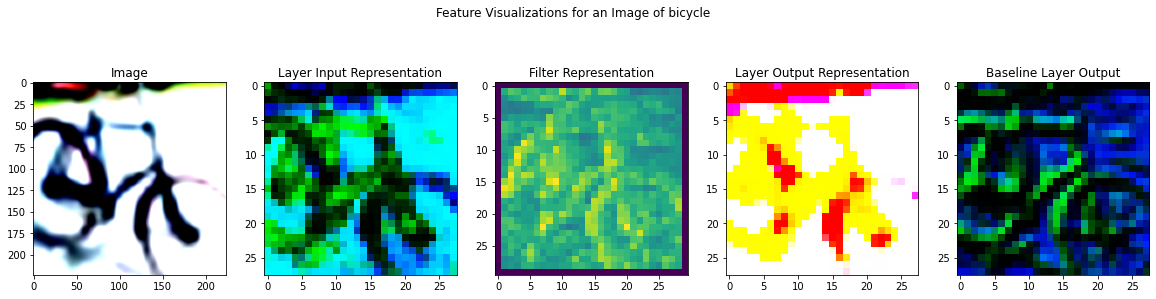

In [267]:
plot_layer_features(features, label_names, cpu_images, index=27)

### Track Missclassifications

In [329]:
@torch.no_grad()
def get_class_characteristics(data_loader, model, id2label):
    class2correctness2image_ids = defaultdict(lambda: defaultdict(lambda: list()))
    all_images = []
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    count = 0
    for idx, (images, target) in tqdm(enumerate(data_loader)):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(images, use_amp=False)
        predictions = output.argsort(dim=-1, descending=True)[:, 0].reshape(-1)
        correctness = predictions == target.reshape(-1)
        
        for batch_idx, (is_correct, label, image) in enumerate(zip(correctness, target, images)):
            count += 1
            label = label.detach().cpu().numpy().tolist()
            is_correct = is_correct.detach().cpu().numpy().tolist()
            class2correctness2image_ids[id2label[label]][is_correct].append(count
            )
            all_images.append(image.detach().cpu().numpy())
            
    return class2correctness2image_ids, all_images

In [305]:
torch.distributions.Categorical(F.softmax(output[0])).entropy().detach().cpu().numpy().tolist()

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


3.574014663696289

In [168]:
class2correctness2image_ids, all_images = get_class_characteristics(data_loader_val, csam_model, id2label)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
79it [00:20,  3.83it/s]


In [308]:
bl_class2correctness2image_ids, _ = get_class_characteristics(data_loader_val, bl_model, id2label)

79it [00:18,  4.28it/s]
0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
79it [00:19,  4.01it/s]


In [269]:
len(all_images), len(_)

(10000, 10000)

In [170]:
len(class2correctness2image_ids)

100

In [202]:
flat_dict = {
    'class': [],
    'correct_frequency': [],
    'wrong_frequency': []
}

for class_name, correctness2image_ids in class2correctness2image_ids.items():
    flat_dict['class'].append(class_name)
    for is_correct, image_ids in correctness2image_ids.items():
        if is_correct:
            flat_dict['correct_frequency'].append(len(image_ids))
        else:
            flat_dict['wrong_frequency'].append(len(image_ids))

In [270]:
csam_df = pd.DataFrame(data=flat_dict)
csam_df = csam_df.set_index('class')
csam_df = csam_df.cumsum(axis=1)
csam_df

,correct_frequency,wrong_frequency
class,,
mountain,94,100
forest,72,100
seal,56,100
mushroom,80,100
sea,85,100
...,...,...
telephone,84,100
bed,84,100
motorcycle,94,100


In [271]:
def dataframify_dict(dictionary):
    flat_dict = {
    'class': [],
    'correct_frequency': [],
    'wrong_frequency': []
    }

    for class_name, correctness2image_ids in dictionary.items():
        flat_dict['class'].append(class_name)
        for is_correct, image_ids in correctness2image_ids.items():
            if is_correct:
                flat_dict['correct_frequency'].append(len(image_ids))
            else:
                flat_dict['wrong_frequency'].append(len(image_ids))
    return pd.DataFrame(data=flat_dict)

In [273]:
bl_df = dataframify_dict(bl_class2correctness2image_ids)
bl_df = bl_df.set_index('class')
bl_df = bl_df.cumsum(axis=1)

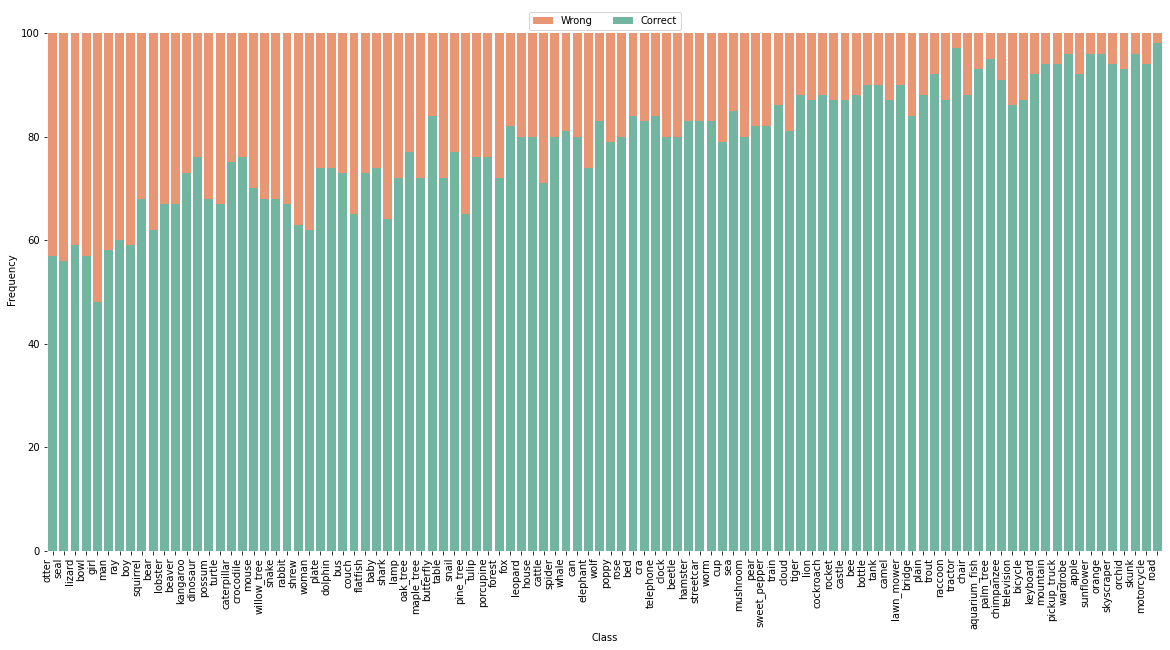

In [275]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = csam_df.index, 
    y = csam_df['wrong_frequency'], 
    label='Wrong',   
    color=sns.color_palette("Set2", 10)[1],
    order = bl_df.sort_values('correct_frequency').index
)

sns.barplot(
    x = csam_df.index, y = csam_df['correct_frequency'], 
    label='Correct',  
    color=sns.color_palette("Set2", 10)[0],
    order = bl_df.sort_values('correct_frequency').index
)

plt.ylabel("Frequency")
plt.xlabel("Class")
ax.legend(ncol=7, loc="upper center", frameon=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

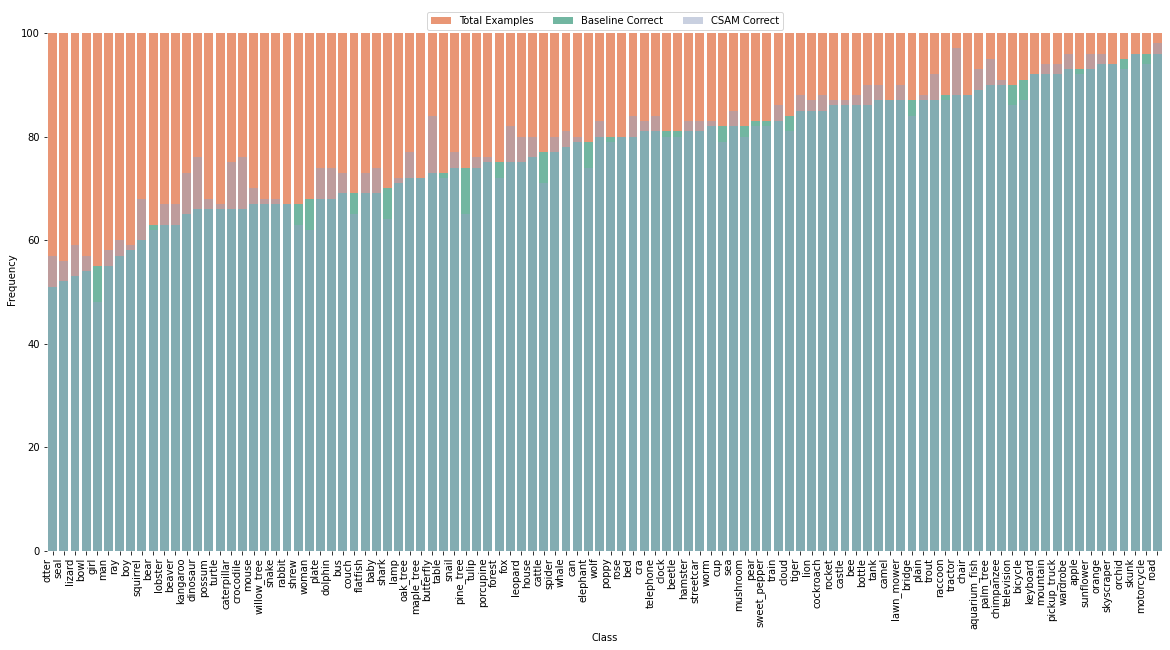

In [284]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = bl_df.index, 
    y = bl_df['wrong_frequency'], 
    label='Total Examples',   
    color=sns.color_palette("Set2", 10)[1],
    order = bl_df.sort_values('correct_frequency').index
)

sns.barplot(
    x = bl_df.index, y = bl_df['correct_frequency'], 
    label='Baseline Correct',  
    color=sns.color_palette("Set2", 10)[0],
    order = bl_df.sort_values('correct_frequency').index
)

sns.barplot(
    x = csam_df.index, y = csam_df['correct_frequency'], 
    label='CSAM Correct',  
    color=sns.color_palette("Set2", 10)[2],
    order = bl_df.sort_values('correct_frequency').index,
    alpha=.5
)


plt.ylabel("Frequency")
plt.xlabel("Class")
ax.legend(ncol=7, loc="upper center", frameon=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [290]:
bl_df = dataframify_dict(bl_class2correctness2image_ids)
csam_df = dataframify_dict(class2correctness2image_ids)
bl_df = bl_df.set_index('class')
csam_df = csam_df.set_index('class')

In [287]:
bl_df, csam_df

(         class  correct_frequency  wrong_frequency
 0     mountain                 92                8
 1       forest                 75               25
 2         seal                 52               48
 3     mushroom                 82               18
 4          sea                 82               18
 ..         ...                ...              ...
 95   telephone                 81               19
 96         bed                 80               20
 97  motorcycle                 96                4
 98        bear                 63               37
 99       tiger                 85               15
 
 [100 rows x 3 columns],
          class  correct_frequency  wrong_frequency
 0     mountain                 94                6
 1       forest                 72               28
 2         seal                 56               44
 3     mushroom                 80               20
 4          sea                 85               15
 ..         ...                ...   

In [293]:
diff_df = bl_df.subtract(csam_df, axis="columns")
diff_df

,correct_frequency,wrong_frequency
class,,
mountain,-2,2
forest,3,-3
seal,-4,4
mushroom,2,-2
sea,-3,3
...,...,...
telephone,-3,3
bed,-4,4
motorcycle,2,-2


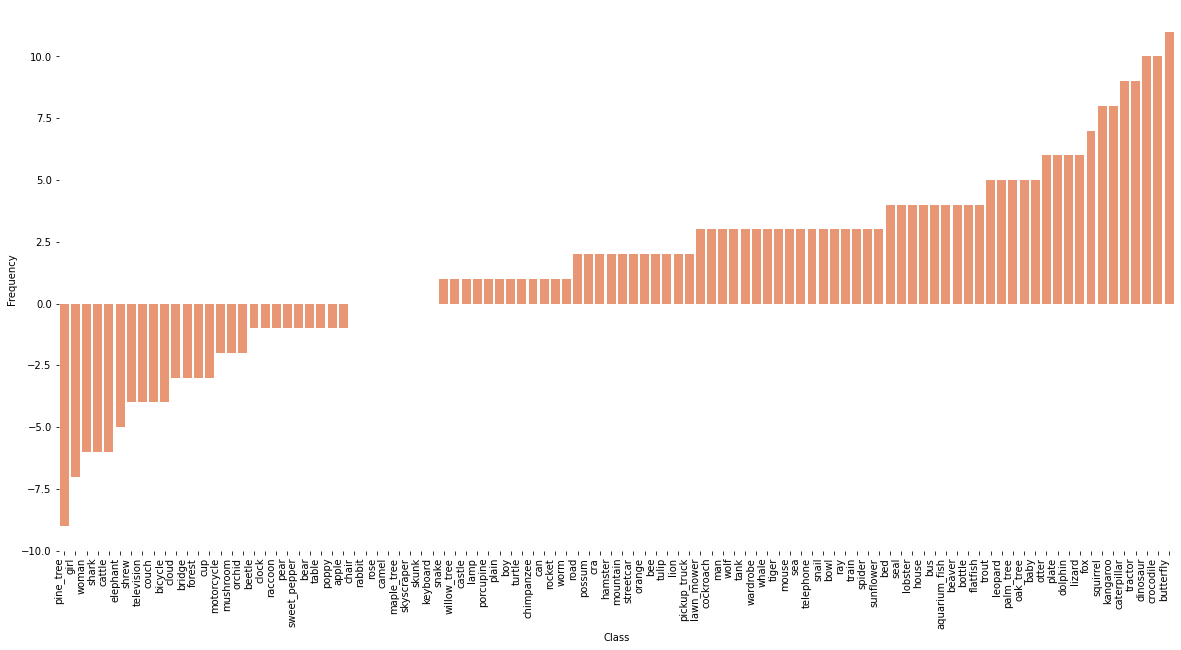

In [294]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = diff_df.index, 
    y = diff_df['wrong_frequency'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)

plt.ylabel("Frequency")
plt.xlabel("Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [332]:
@torch.no_grad()
def get_class_entropies(data_loader, model, id2label):
    class2correctness2entropies = defaultdict(lambda: defaultdict(lambda: list()))
    model.eval()

    end = time.time()
    count = 0
    for idx, (images, target) in tqdm(enumerate(data_loader)):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        outputs = model(images, use_amp=False)
        predictions = outputs.argsort(dim=-1, descending=True)[:, 0].reshape(-1)
        correctness = predictions == target.reshape(-1)
        
        for batch_idx, (is_correct, label, image, output) in enumerate(zip(correctness, target, images, outputs)):
            count += 1
            label = label.detach().cpu().numpy().tolist()
            is_correct = is_correct.detach().cpu().numpy().tolist()
            output_entropy = torch.distributions.Categorical(
                F.softmax(output)
            ).entropy().detach().cpu().numpy().tolist()
            class2correctness2entropies[id2label[label]][is_correct].append(output_entropy)
            
    return class2correctness2entropies

def dataframify_entropy_dict(dictionary):
    flat_dict = {
    'class': [],
    'correct_entropy': [],
    'wrong_entropy': [],
    'overall': []
    }

    for class_name, correctness2entropies in dictionary.items():
        flat_dict['class'].append(class_name)
        for is_correct, entropies in correctness2entropies.items():
            if is_correct:
                flat_dict['correct_entropy'].append(np.mean(entropies))
            else:
                flat_dict['wrong_entropy'].append(np.mean(entropies))
        flat_dict['overall'].append(
            np.concatenate(list(correctness2entropies.values())).mean()
        )
    return pd.DataFrame(data=flat_dict)

In [313]:
bl_class2correctness2entropies = get_class_entropies(data_loader_val, bl_model, id2label)

0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
79it [00:19,  3.99it/s]


In [335]:
bl_entropy_df = dataframify_entropy_dict(bl_class2correctness2entropies)
bl_entropy_df = bl_entropy_df.set_index('class')
bl_entropy_df

,correct_entropy,wrong_entropy,overall
class,,,
mountain,1.361158,2.664953,1.465461
forest,1.808508,2.846555,2.068019
seal,1.818545,2.708327,2.245640
mushroom,0.983915,2.893839,1.327701
sea,1.248499,2.397744,1.455363
...,...,...,...
telephone,0.997596,2.770604,1.334467
bed,1.396331,2.449626,1.606990
motorcycle,0.980874,2.595719,1.045468


In [330]:
csam_class2correctness2entropies = get_class_entropies(data_loader_val, csam_model, id2label)

0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
79it [00:21,  3.74it/s]


In [336]:
csam_entropy_df = dataframify_entropy_dict(csam_class2correctness2entropies)
csam_entropy_df = csam_entropy_df.set_index('class')
csam_entropy_df

,correct_entropy,wrong_entropy,overall
class,,,
mountain,1.198716,2.526701,1.278395
forest,1.686751,2.628684,1.950492
seal,1.638628,2.757384,2.130881
mushroom,1.070167,2.902520,1.436638
sea,1.215064,2.246326,1.369753
...,...,...,...
telephone,1.145631,2.457282,1.355495
bed,1.225850,2.387160,1.411659
motorcycle,1.007297,2.397612,1.090716


In [338]:
ratio_df = bl_entropy_df.divide(csam_entropy_df, axis="columns")
ratio_df

,correct_entropy,wrong_entropy,overall
class,,,
mountain,1.135513,1.054716,1.146329
forest,1.072184,1.082882,1.060255
seal,1.109797,0.982209,1.053855
mushroom,0.919403,0.997009,0.924172
sea,1.027517,1.067407,1.062500
...,...,...,...
telephone,0.870783,1.127507,0.984487
bed,1.139072,1.026168,1.138370
motorcycle,0.973768,1.082627,0.958515


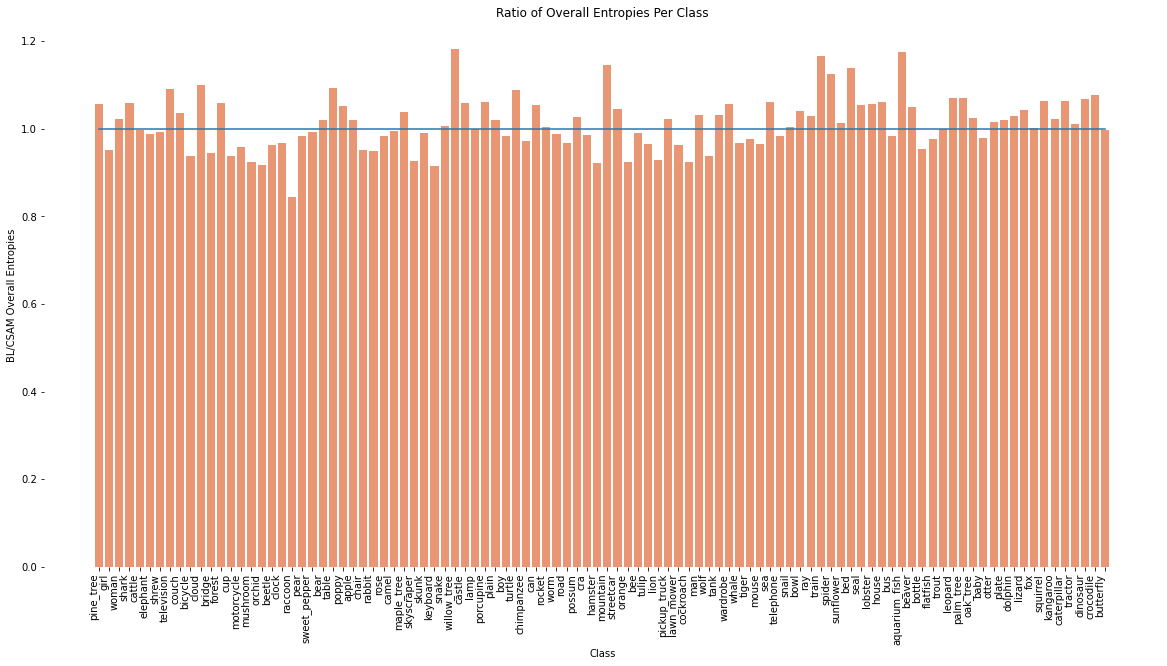

In [345]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['overall'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Overall Entropies")
plt.xlabel("Class")
plt.title("Ratio of Overall Entropies Per Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [346]:
(ratio_df['overall'] > 1.).sum()

54

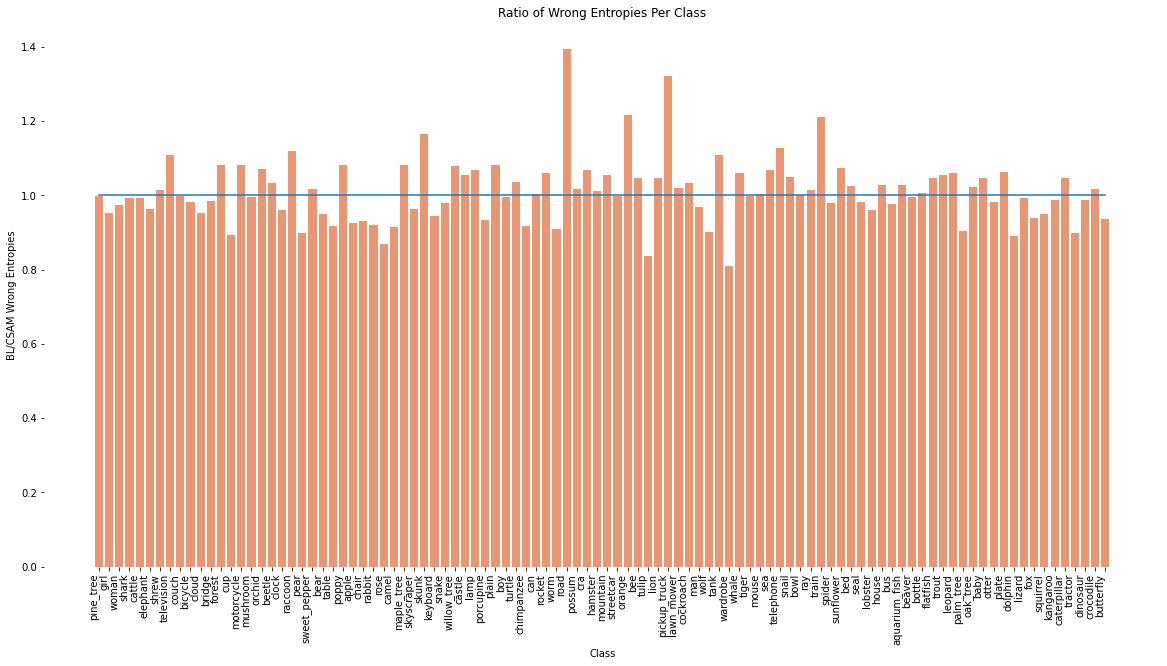

In [344]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['wrong_entropy'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Wrong Entropies")
plt.xlabel("Class")
plt.title("Ratio of Wrong Entropies Per Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [347]:
(ratio_df['wrong_entropy'] > 1.).sum()

51

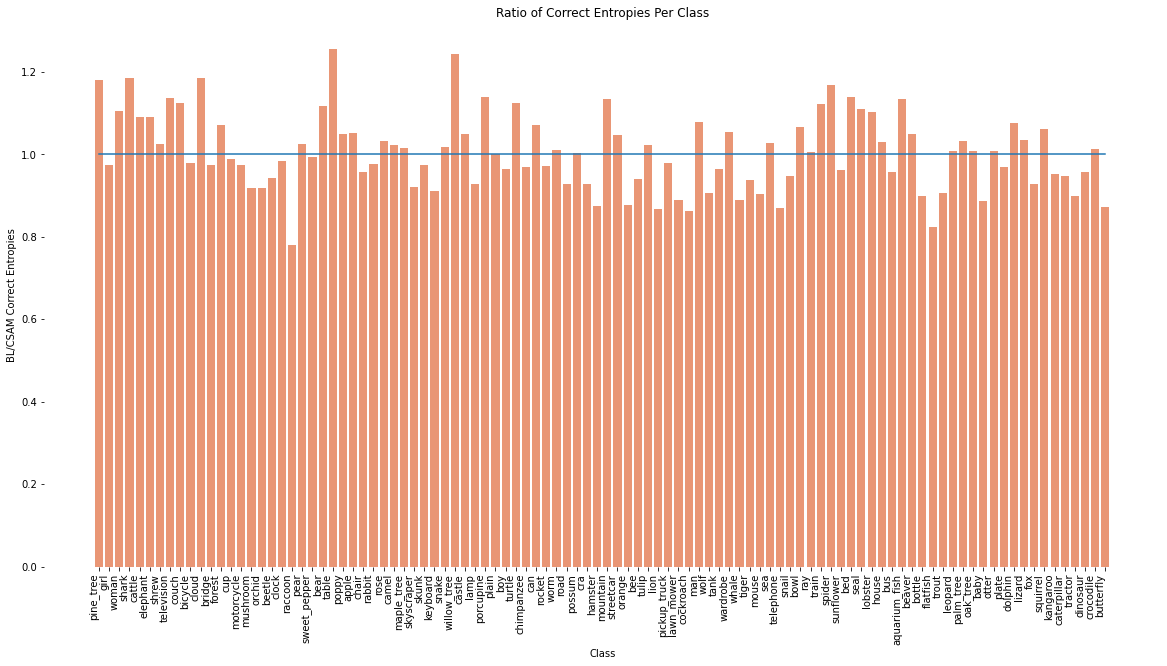

In [355]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['correct_entropy'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Correct Entropies")
plt.xlabel("Class")
plt.title("Ratio of Correct Entropies Per Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [348]:
(ratio_df['correct_entropy'] > 1.).sum()

51

In [352]:
def forward_features(self, x, skip_layer=None):
    x = self.patch_embed(x)
    if self.ape:
        x = x + self.absolute_pos_embed
    x = self.pos_drop(x)

    for i, layer in enumerate(self.layers):
        if skip_layer is not None and i == skip_layer:
            continue    
        x = layer(x)

    x = self.norm(x)  # B L C
    x = self.avgpool(x.transpose(1, 2))  # B C 1
    x = torch.flatten(x, 1)
    return x

def forward(self, x, use_amp=False, skip_layer=None):
    x = forward_features(self, x, skip_layer=skip_layer)
    x = self.head(x)

    return x

@torch.no_grad()
def skip_layer_validate(config, data_loader, model, accumulation_steps=1, skip_layer=1):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    for idx, (images, target) in enumerate(data_loader):
        formatted_images = images.cuda(non_blocking=True).unsqueeze(0)
        formatted_target = target.cuda(non_blocking=True).unsqueeze(0)
        
        A, B, C, H, W = formatted_images.shape
        A, B = formatted_target.shape
        if B // accumulation_steps == 0:
            zero_idx = 1
            ones_idx = B
        else:
            zero_idx = accumulation_steps
            ones_idx = B // accumulation_steps
        formatted_images = formatted_images.reshape(zero_idx, ones_idx, C, H, W)
        formatted_target = formatted_target.reshape(zero_idx, ones_idx)
        
        for accumulation_step in range(accumulation_steps):
            images = formatted_images[accumulation_step]
            target = formatted_target[accumulation_step]
        
            # compute output
            output = forward(model, images, False, skip_layer=skip_layer)
#             output = model(images, use_amp=False)

            # measure accuracy and record loss
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            loss_meter.update(loss.item(), target.size(0))
            acc1_meter.update(acc1.item(), target.size(0))
            acc5_meter.update(acc5.item(), target.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if idx % config.PRINT_FREQ == 0:
                memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
                print(
                    f'Test: [{idx}/{len(data_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                    f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'
                    f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'
                    f'Mem {memory_used:.0f}MB')
            images = images.cpu()
            target = target.cpu()
    print(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg

In [353]:
skip_layer_validate(config, data_loader_val, csam_model, accumulation_steps=2, skip_layer=1)

Test: [0/79]	Time 2.971 (2.971)	Loss 5.0874 (5.0874)	Acc@1 1.562 (1.562)	Acc@5 14.062 (14.062)	Mem 36575MB
Test: [0/79]	Time 0.199 (1.585)	Loss 5.1761 (5.1318)	Acc@1 0.000 (0.781)	Acc@5 7.812 (10.938)	Mem 36575MB
Test: [10/79]	Time 0.095 (0.236)	Loss 5.3106 (5.1741)	Acc@1 3.125 (2.009)	Acc@5 7.812 (9.449)	Mem 36575MB
Test: [10/79]	Time 0.091 (0.229)	Loss 5.2078 (5.1757)	Acc@1 3.125 (2.060)	Acc@5 4.688 (9.233)	Mem 36575MB
Test: [20/79]	Time 0.096 (0.166)	Loss 5.2179 (5.1699)	Acc@1 1.562 (2.134)	Acc@5 10.938 (9.527)	Mem 36575MB
Test: [20/79]	Time 0.091 (0.164)	Loss 5.2028 (5.1707)	Acc@1 1.562 (2.121)	Acc@5 10.938 (9.561)	Mem 36575MB
Test: [30/79]	Time 0.095 (0.142)	Loss 5.1343 (5.1615)	Acc@1 0.000 (1.998)	Acc@5 4.688 (9.170)	Mem 36575MB
Test: [30/79]	Time 0.091 (0.141)	Loss 5.3647 (5.1648)	Acc@1 0.000 (1.966)	Acc@5 1.562 (9.047)	Mem 36575MB
Test: [40/79]	Time 0.095 (0.130)	Loss 5.4312 (5.1774)	Acc@1 0.000 (1.813)	Acc@5 1.562 (8.758)	Mem 36575MB
Test: [40/79]	Time 0.091 (0.130)	Loss 5.313

(1.72, 8.65, 5.171101402282715)

In [354]:
skip_layer_validate(config, data_loader_val, csam_model, accumulation_steps=2, skip_layer=None)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test: [0/79]	Time 2.747 (2.747)	Loss 0.7295 (0.7295)	Acc@1 79.688 (79.688)	Acc@5 96.875 (96.875)	Mem 36575MB
Test: [0/79]	Time 0.173 (1.460)	Loss 0.8357 (0.7826)	Acc@1 81.250 (80.469)	Acc@5 98.438 (97.656)	Mem 36575MB
Test: [10/79]	Time 0.104 (0.234)	Loss 1.0313 (0.8967)	Acc@1 75.000 (79.018)	Acc@5 90.625 (94.866)	Mem 36575MB
Test: [10/79]	Time 0.099 (0.227)	Loss 0.9294 (0.8981)	Acc@1 73.438 (78.764)	Acc@5 95.312 (94.886)	Mem 36575MB
Test: [20/79]	Time 0.111 (0.170)	Loss 1.0398 (0.8885)	Acc@1 75.000 (78.811)	Acc@5 92.188 (94.855)	Mem 36575MB
Test: [20/79]	Time 0.101 (0.168)	Loss 0.8757 (0.8882)	Acc@1 78.125 (78.795)	Acc@5 96.875 (94.903)	Mem 36575MB
Test: [30/79]	Time 0.104 (0.148)	Loss 1.0252 (0.8940)	Acc@1 76.562 (78.227)	Acc@5 98.438 (95.005)	Mem 36575MB
Test: [30/79]	Time 0.100 (0.147)	Loss 0.6829 (0.8906)	Acc@1 84.375 (78.327)	Acc@5 96.875 (95.035)	Mem 36575MB
Test: [40/79]	Time 0.110 (0.137)	Loss 0.7961 (0.8862)	Acc@1 79.688 (78.607)	Acc@5 96.875 (95.177)	Mem 36575MB
Test: [40/79

(79.01, 95.43, 0.8697982761383056)

# Experiment Results Plots

In [14]:
csam_swin_filter5 = [77.02, 77.17, 77.17, 73.05]
csam_swin_filter3 = [78.12, 78.82, 24.59, 14.61]
baseline = [77.58] * 4

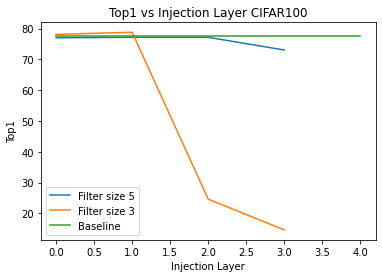

In [19]:
plt.plot(csam_swin_filter5, label="Filter size 5")
plt.plot(csam_swin_filter3, label="Filter size 3")
plt.plot(baseline, label="Baseline")
plt.title("Top1 vs Injection Layer CIFAR100")
plt.xlabel("Injection Layer")
plt.ylabel("Top1")
plt.legend()
plt.show()